In [37]:
%matplotlib inline

import numpy as np
np.random.seed(2016)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import datetime
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

from scipy.misc import imread
from scipy.misc import imresize

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import __version__ as keras_version

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

In [38]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
DATA_PATH = '/a/data/fisheries_monitoring/data/classifiers/superbox/'

In [39]:
aug_folders = glob.glob(DATA_PATH + '*')
for folder in aug_folders:
    print "folder name:", folder

folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/invert
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/vflip
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/add
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/emboss
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/gaussianNoise
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/blur
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/original
folder name: /a/data/fisheries_monitoring/data/classifiers/superbox/rotate


In [40]:
def load_all_labels(aug_folders):
    img = []
    file_class = []
    for folder in aug_folders:
        folder_name = os.path.basename(folder)
        print('Loading augmentation: {}'.format(folder_name))
        classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
        for idx, cls in enumerate(classes):
    #         print('Loading class {}, (index {})'.format(cls, idx))
            path = os.path.join(DATA_PATH, folder, cls, '*.jpg')
            files = sorted(glob.glob(path))
            for fl in files:
                flbase = os.path.basename(fl)
                img.append(folder_name + '/' + cls + '/' + flbase)
                file_class.append(idx) 
    all_labels = pd.DataFrame({"img":img, "classes":file_class})
    all_labels = all_labels[["img", "classes"]]
    return all_labels


def train_val_test_split(all_labels, val_size, test_size):
    all_labels = shuffle(all_labels, random_state = 8574)
    test_labels = all_labels[0:test_size]
    val_labels = all_labels[test_size:test_size + val_size]
    train_labels = all_labels[test_size + val_size:]
    return train_labels, val_labels, test_labels


def data_generator(batch_size, labels, INPUT_WIDTH, INPUT_HEIGHT):
    while True:
        img_batch = np.zeros((batch_size, INPUT_WIDTH, INPUT_HEIGHT, 3))
        class_batch = np.zeros((batch_size, 8))
        for i in xrange(batch_size):
            n = np.random.choice(len(labels))
            file_name = labels.iloc[n]["img"]
            path = DATA_PATH + file_name
            img = image.load_img(path)
            img = img.resize((INPUT_WIDTH, INPUT_HEIGHT))
            img = image.img_to_array(img)
            img /= 255
            img_batch[i] = img
            
            class_batch[i] = np_utils.to_categorical(labels.iloc[n]["classes"], 8)
        
        yield (img_batch, class_batch)


def load_data(labels, INPUT_WIDTH, INPUT_HEIGHT):
    X = []
    y = []
    idx = []
    X_raw = []
    y_raw = [] 
    shape_raw = []
    for i in xrange(len(labels)):
        file_name = labels.iloc[i]["img"]
        path = DATA_PATH + file_name
        img_raw = image.load_img(path)
        img = img_raw.resize((INPUT_WIDTH,INPUT_HEIGHT))
        
        img_raw = image.img_to_array(img_raw)
        img_raw /= 255
        img = image.img_to_array(img)
        img /= 255
        
        file_class = labels.iloc[i]["classes"]

        X.append(img)
        y.append(file_class)
        idx.append(file_name)
        X_raw.append(img_raw)
        
        if (i+1) in [k*len(labels)/5 for k in xrange(1,6)]:
                print "Loading...{}% done!".format((i+2)*100/len(labels))
        
    return np.array(X), np.array(y), np.array(idx), np.array(X_raw)


def visualize_prediction(img, index = None, true_box = None, pred_box = None, ax = None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(12,8))
    ax.imshow(img)
    if index is not None:
        ax.set_title(index)
    height = img.shape[0]
    width = img.shape[1]
    
    if true_box is not None:
        x, y, w, h = true_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='\\',
            fill=False,      # remove background
            color = 'r',
            linewidth = 2.5
                )
            )
    if pred_box is not None:
        x, y, w, h = pred_box
        x = x * width
        y = y * height
        w = w * width
        h = h * height
        ax.add_patch(
        patches.Rectangle(
            (x, y), # x,y
            w, # width
            h, # height
            hatch='-',
            fill=False,      # remove background
            color = 'k',
            linewidth = 2.5
                )
            )

def make_plot(data, nrow = 2, ncol = 2, index = None, true_box = None, pred_box = None, figsize = (15,8)):
    # Create grid
    _, ax = plt.subplots(nrow, ncol, figsize=figsize)
    
    idx = None
    tbox = None
    pbox = None
    # Generate indices of images to show
    for axi in np.ravel(ax):
        n = np.random.choice(len(data))
        img = data[n]
        if index is not None:
            idx = index[n]
        if true_box is not None:
            tbox = true_box[n]
        if pred_box is not None:
            pbox = pred_box[n]
        
        # Visualize it along with the box
        visualize_prediction(img, index = idx, true_box = tbox, pred_box = pbox, ax = axi)

In [41]:
all_labels = load_all_labels(aug_folders)

Loading augmentation: invert
Loading augmentation: vflip
Loading augmentation: add
Loading augmentation: emboss
Loading augmentation: gaussianNoise
Loading augmentation: blur
Loading augmentation: original
Loading augmentation: rotate


In [42]:
selected_aug = {"ALB" : ["original", "rotate"],
                "BET" : ["original", "rotate", "invert", "add", "emboss", "gaussianNoise", "blur"],
                "DOL" : ["original", "rotate", "invert", "add", "emboss", "gaussianNoise", "blur"],
                "LAG" : ["original", "rotate", "invert", "add", "emboss", "gaussianNoise", "blur"],
                "NoF" : ["original", "rotate", "add", "emboss", "gaussianNoise", "blur"],
                "OTHER" : ["original", "rotate", "invert", "add", "emboss", "gaussianNoise", "blur"],
                "SHARK" : ["original", "rotate", "invert", "add", "emboss", "gaussianNoise", "blur"],
                "YFT" : ["original", "rotate", "add", "blur"]}
selected_labels = pd.DataFrame(columns = ["img", "classes"])
for key, values in selected_aug.iteritems():
    for value in values:
        labels_tmp = all_labels[all_labels["img"].str.startswith(value + '/' + key)]
        selected_labels = selected_labels.append(labels_tmp)
selected_labels["classes"] = selected_labels["classes"].astype(int)

Size of original data: 3777 	Size of augmented data: 60846 	times augmented: 16.1096108022
For each class:
Original size: 1719 	After augmentation: ALB 6876 	times augmented: 4.0
Original size: 200 	After augmentation: BET 6800 	times augmented: 34.0
Original size: 117 	After augmentation: DOL 3978 	times augmented: 34.0
Original size: 67 	After augmentation: LAG 2278 	times augmented: 34.0
Original size: 465 	After augmentation: NoF 13020 	times augmented: 28.0
Original size: 299 	After augmentation: OTHER 10166 	times augmented: 34.0
Original size: 176 	After augmentation: SHARK 5984 	times augmented: 34.0
Original size: 734 	After augmentation: YFT 11744 	times augmented: 16.0


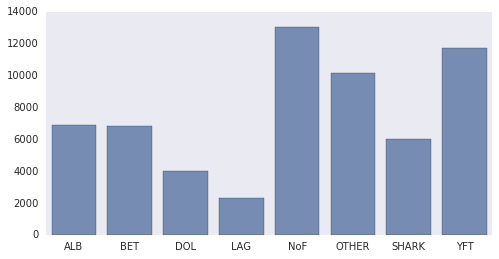

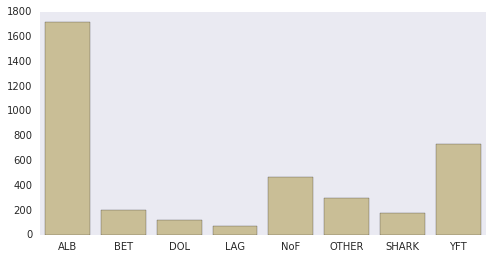

In [43]:
train_files = all_labels[all_labels["img"].str.startswith("original")]["img"]

categories = np.array([name[9:-14] for name in train_files])
cat = pd.Series(categories).value_counts()
cat = cat.sort_index()

count = {}
for key in selected_aug:
    count[key] = len(selected_labels[selected_labels["img"].str.contains(key)])
count = pd.Series(count)
plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8, color=p[0])
plt.figure(figsize=(8,4))
sns.barplot(cat.index, cat.values, alpha=0.8, color=p[4])
print "Size of original data:", len(train_files), '\t', "Size of augmented data:", len(selected_labels), \
      "\t", "times augmented:", len(selected_labels)/float(len(train_files))
print "For each class:"
for key in count.index:
    print "Original size:", cat[key], '\t', "After augmentation:", key, count[key], \
          '\t', "times augmented:", float(count[key])/cat[key]

In [44]:
train_labels, val_labels, test_labels = train_val_test_split(selected_labels, 12000, 6000)
X_test, y_test, id_test, X_test_raw = load_data(test_labels, INPUT_WIDTH, INPUT_HEIGHT)

Loading...20% done!
Loading...40% done!
Loading...60% done!
Loading...80% done!
Loading...100% done!


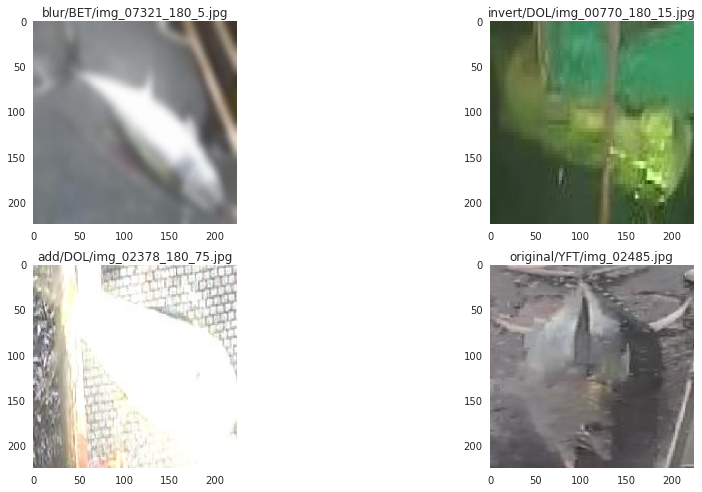

In [51]:
make_plot(data = X_test, nrow = 2, ncol = 2, index = id_test, figsize = (15,8))

In [52]:
base_model = ResNet50(weights='imagenet', include_top = False, input_shape=(224,224,3))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(8, activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [66]:
batch_size = 30
steps_per_epoch = 100
nb_epoch = 5
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),]

history = model.fit_generator(generator = data_generator(batch_size, train_labels, INPUT_WIDTH, INPUT_HEIGHT), 
                              steps_per_epoch = steps_per_epoch,
                              epochs=nb_epoch,
                              verbose=1,
#                             callbacks = callbacks,
                              validation_data = data_generator(batch_size, val_labels, INPUT_WIDTH, INPUT_HEIGHT),
                              validation_steps = 30)
model.save('/a/data/fisheries_monitoring/data/models/classifiers/ResNet50_SuperBox.h5')

Epoch 1/5
100/100 [==============================] - 44s - loss: 0.2613 - val_loss: 0.3200

In [67]:
predictions_valid = model.predict(X_test.astype('float32'), batch_size=batch_size, verbose=1)
score = log_loss(y_test, predictions_valid)
print "log loss score: ", score

6000/6000 [==============================] - 71s     

In [68]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(predictions_valid, axis = 1)
acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
print "accuracy: ", acc

accuracy:  0.924333333333


In [69]:
print y_test[0:35]
print y_pred[0:35]

print y_test[35:70]
print y_pred[35:70]

[0 1 4 7 7 0 7 2 7 6 5 0 1 2 5 7 0 2 0 7 1 7 6 4 1 7 3 3 7 5 4 6 5 4 4]
[0 1 4 7 7 0 7 5 7 6 5 0 1 2 5 0 0 2 0 7 1 7 6 4 7 7 3 3 7 5 4 6 5 4 4]
[7 1 7 1 5 0 2 5 1 5 5 0 5 4 7 5 4 5 0 1 1 5 1 1 4 6 4 7 0 6 5 4 4 7 0]
[7 5 7 1 5 0 2 5 1 5 5 7 5 4 7 5 4 5 0 7 7 5 1 1 4 6 4 7 3 6 5 4 4 7 0]
